# MNIST

MNIST (Mixed National Institute of Standards and Technology)  is a database of handwritten digits (0-9). The MNIST database contains 60,000 training images and 10,000 testing images. The images were gathered from high school students and employees of the United States Census Bureau. The image below is a sample of data in MNIST


In [1]:
from IPython.display import Image
Image(url= "https://user-images.githubusercontent.com/22493191/49306320-cecdd580-f4c9-11e8-9a19-b64d8fb7994e.png")

# File Format of the MNIST Database

[From the offical MNIST website](http://yann.lecun.com/exdb/mnist/)

The data is stored in a very simple file format designed for storing vectors and multidimensional matrices. General info on this format is given at the end of this page, but you don't need to read that to use the data files.
All the integers in the files are stored in the MSB first (high endian) format used by most non-Intel processors. Users of Intel processors and other low-endian machines must flip the bytes of the header.

There are 4 files:

train-images-idx3-ubyte: training set images  
train-labels-idx1-ubyte: training set labels   
t10k-images-idx3-ubyte:  test set images   
t10k-labels-idx1-ubyte:  test set labels  

The training set contains 60000 examples, and the test set 10000 examples.
The files need to be downloaded from [here](http://yann.lecun.com/exdb/mnist/). Then place them in a folder called data to run the rest of this code. Image below shows the needed files.



In [2]:
Image(url= "https://user-images.githubusercontent.com/22493191/49309618-bb276c80-f4d3-11e8-99f9-71f7c91b4611.png")

## Reading bytes from files

In [3]:
import os.path
import gzip
import numpy as np
import matplotlib.pyplot as plt
import keras as kr
import sklearn.preprocessing as pre

C:\Users\KMora\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Above we have all the imports we will use. Below we start by unzipping the images. 

In [4]:
Image(url= "https://user-images.githubusercontent.com/22493191/49309623-bf538a00-f4d3-11e8-81a0-6af3d3d320f1.png")

In [5]:
# Adapted from: https://docs.python.org/3/library/gzip.html

with gzip.open('data/train-images-idx3-ubyte.gz', 'rb') as f:
    file_content = f.read()

Now we will run a command that will tell us the type that we have read in. 

In [6]:
type(file_content)

bytes

Now we will view the first byte written hexi

In [7]:
file_content[0:4]

b'\x00\x00\x08\x03'

## Big Endian and Little Endian
In this code we will be using Big Endian as oposed to Little Endian. Below is a breif explanation of both but you can find a more detailed one [here](https://searchnetworking.techtarget.com/definition/big-endian-and-little-endian)

Big Endian Byte Order: The most significant byte (the "big end") of the data is placed at the byte with the lowest address. The rest of the data is placed in order in the next three bytes in memory.

Little Endian Byte Order: The least significant byte (the "little end") of the data is placed at the byte with the lowest address. The rest of the data is placed in order in the next three bytes in memory.

We will now change these bytes to ints and they should match our magic number from the image above.

In [8]:
# Adapted from: https://stackoverflow.com/questions/51220161/how-to-convert-from-bytes-to-int

int.from_bytes(file_content[0:4], byteorder='big')

2051

Now we will check how many images are in the file as thats what the next four bytes show

In [9]:
int.from_bytes(file_content[4:8], byteorder='big')

60000

Now we will check how many rows which should be 28

In [10]:
int.from_bytes(file_content[8:12], byteorder='big')

28

Now we will check how many columns which should also be 28

In [11]:
int.from_bytes(file_content[12:16], byteorder='big')

28

## Reading a single image

Now we know that each image is row by column which is 28 by 28 pixels (784) we should be able to read in the first image by displaying the bits from 16 to 800.
But first we have to reshape the bits into a 28 x 28 array using the numpy package

In [33]:
image = np.array(list(file_content[16:800])).reshape(28,28).astype(np.uint8)

Now that we have read in the first image we are going to use matplotlib to display the image. 

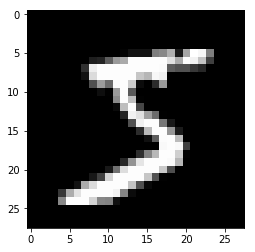

In [34]:
%matplotlib inline
plt.imshow(image, cmap='gray')

So as we can see its a 5. Now if you want to grab another image all you have to do is change the 16:800 from above to 800:1584 for the second or 1584:2386 for the third and so on and so forth. Just keep adding 784 each time. 

## Reading a label
Labels will be read in much the same way as the images 

In [17]:
# Adapted from: https://docs.python.org/3/library/gzip.html

with gzip.open('data/train-labels-idx1-ubyte.gz', 'rb') as f:
    labels = f.read()

This will again tel us the type of file we have read in 

In [35]:
type(labels)

bytes

In [36]:
labels[0:4]

b'\x00\x00\x08\x01'

This will give us the magic number as the image above shows

In [37]:
int.from_bytes(labels[0:4], byteorder='big')

2049

We will check how many labels we should have

In [38]:
int.from_bytes(labels[4:8], byteorder='big')

60000

Now we will read in the bytes that will tell us the label of the first number. The labels are only one byte so if you want to know the label of the second number you would change the below code as int.from_bytes(labels[9:10], byteorder="big"). 

In [41]:
int.from_bytes(labels[8:9], byteorder="big")

5

## Neural network

In [19]:
from keras.layers import Dense, Dropout, Activation
from keras.models import Model

# Start a neural network, building it by layers.
model = kr.models.Sequential()

# Add a hidden layer with 1000 neurons and an input layer with 784.
model.add(kr.layers.Dense(units=1000, activation='relu', input_dim=784))
model.add(Dropout(0.2)) #Dropout is a technique where randomly selected neurons are ignored during training. 
# They are “dropped-out” randomly. 
# This means that their contribution to the activation of downstream neurons is temporally removed on the 
# forward pass and any weight updates are not applied to the neuron on the backward pass.
model.add(kr.layers.Dense(units=1000, activation='relu'))
model.add(Dropout(0.2))
model.add(kr.layers.Dense(units=1000, activation='relu'))
model.add(Dropout(0.2))
model.add(kr.layers.Dense(units=1000, activation='relu'))


# Add a 10 neuron output layer.
model.add(kr.layers.Dense(units=10, activation='softmax'))

# Build the graph.
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [20]:
with gzip.open('data/train-images-idx3-ubyte.gz', 'rb') as f:
    train_img = f.read()

with gzip.open('data/train-labels-idx1-ubyte.gz', 'rb') as f:
    train_lbl = f.read()
    
train_img = ~np.array(list(train_img[16:])).reshape(60000, 28, 28).astype(np.uint8)
train_lbl =  np.array(list(train_lbl[ 8:])).astype(np.uint8)

In [21]:
inputs = train_img.reshape(60000, 784)/255

In [22]:
# For encoding categorical variables.

encoder = pre.LabelBinarizer()
encoder.fit(train_lbl)
outputs = encoder.transform(train_lbl)

print(train_lbl[0], outputs[0])

5 [0 0 0 0 0 1 0 0 0 0]


In [23]:
model.fit(inputs, outputs, epochs=1, batch_size=100)

Epoch 1/1
60000/60000 [==============================] - 94s 2ms/step - loss: 1.1402 - acc: 0.6450


In [24]:
# save the current model
# code sourced https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model
kr.models.save_model(
    model,
    "savedModel.h5py",
    overwrite=True,
    include_optimizer=True
)

In [25]:
# if the model file exists load it
if os.path.isfile('savedModel.h5py'): 
    model = kr.models.load_model('savedModel.h5py')

In [26]:
with gzip.open('data/t10k-images-idx3-ubyte.gz', 'rb') as f:
    test_img = f.read()

with gzip.open('data/t10k-labels-idx1-ubyte.gz', 'rb') as f:
    test_lbl = f.read()
    
test_img = ~np.array(list(test_img[16:])).reshape(10000, 784).astype(np.uint8)
test_lbl =  np.array(list(test_lbl[ 8:])).astype(np.uint8)

In [27]:
(encoder.inverse_transform(model.predict(test_img)) == test_lbl).sum()

8735

## End